# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from os.path import join

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
plt.rcParams['savefig.dpi'] = 300
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go
import textwrap

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
# from alibi.explainers import ALE, plot_ale

# SHAP
import shap

# GeoPandas (for plotting)
import geopandas as gpd

## Parameters

In [4]:
scope = 'OFF'

input_path = f'../data/2_processed/ML_dataset_{scope}.pkl'
# model_folder = f'{scope}/model_dumps/classifier'
model_folder = ''

train_years = [2021]
test_years = [2022]

subsample_frac = None
run_ALE = False

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
    'Qty'
]

features = features_to_encode + other_features

In [5]:
province_codes = {
    'Milano': 'MI',
    'Belluno': 'BL',
    'Bologna': 'BO',
    'Verona': 'VR',
    'Bolzano': 'BZ',
    'Bergamo': 'BG',
    'Cuneo': 'CN',
    'Vicenza': 'VI',
    'Pordenone': 'PN',
    'Lodi': 'LO',
    'Brescia': 'BS',
    'Treviso': 'TV',
    'Venezia': 'VE',
    'Sondrio': 'SO',
    'Verbano-Cusio-Ossola': 'VB',
    'Como': 'CO',
    'Aosta': 'AO',
    'Torino': 'TO',
    'Trento': 'TN',
    'Gorizia': 'GO',
    'Vercelli': 'VC',
    'Novara': 'NO',
    'Pavia': 'PV',
    'Mantova': 'MN',
    'Ravenna': 'RA',
    'Varese': 'VA',
    'Ferrara': 'FE',
    'Udine': 'UD',
    'Savona': 'SV',
    'Piacenza': 'PC',
    'La Spezia': 'SP',
    'Genova': 'GE',
    'Reggio Emilia': 'RE'
}

## Functions

In [6]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

# Main

## Load data

In [7]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

3,574,411


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.419,False,0.0,195.5
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.433,False,0.0,195.5
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.451,False,0.0,195.5


In [8]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Input dataset is composed of 3,574,411 observations
3.6% bids accepted in the input dataset

Training data is composed of 666,468 observations and correspond to years 2021
3.8% bids accepted in the training data

Test data is composed of 612,577 observations and correspond to years 2022
3.4% bids accepted in the test data


In [9]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['MargTech' 'WorkDay' 'Prov' 'Tech' 'hour' 'SC_PC1' 'SC_PC2' 'IN_PC1'
 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP' 'SellMGP' 'SolarAngle' 'DeclAngle'
 'PVnew' 'PriceDiff' 'Qty']


## Load model

In [10]:
# model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
model_path = 'model_new.pkl'
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model model_new.pkl loaded



In [9]:
clf_pipeline = make_pipeline(feature_transformer, clf)

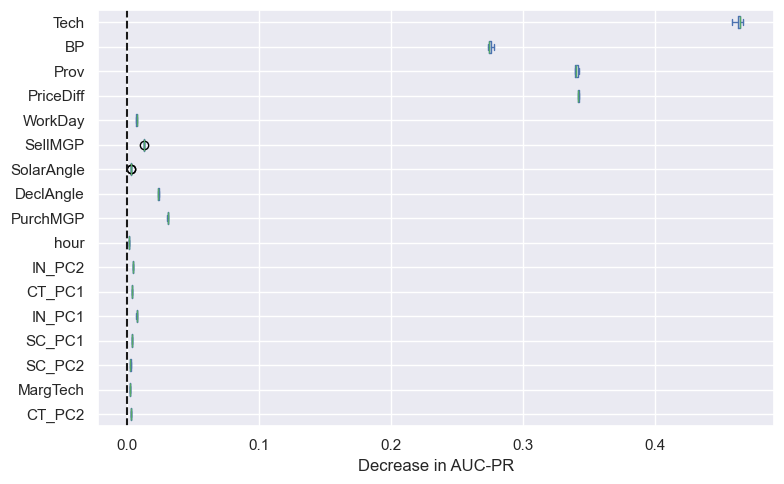

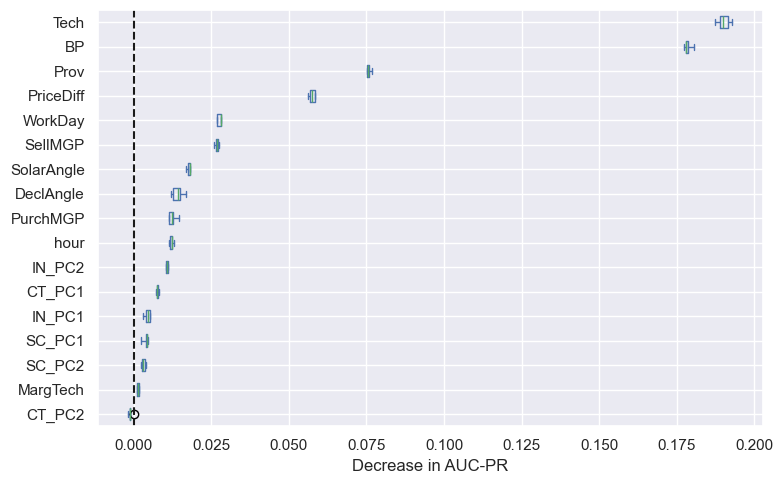

In [12]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['BP' if col == 'PVnew' else col for col in columns]

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=columns,
)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
# for name, importances in zip(["train"], [train_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(8,5))
    # ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in AUC-PR")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

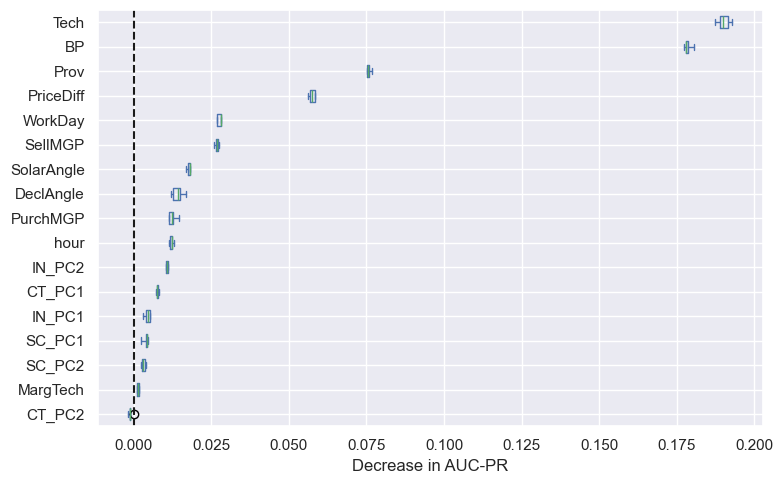

In [13]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['BP' if col == 'PVnew' else col for col in columns]
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)
ax = test_importances.plot.box(vert=False, whis=10, figsize=(8,5))
# ax.set_title(f"Permutation Importances ({name} set)")
ax.set_xlabel("Decrease in AUC-PR")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/pfi_{scope}_test.png')

In [14]:
test_importances

,CT_PC2,MargTech,SC_PC2,SC_PC1,IN_PC1,CT_PC1,IN_PC2,hour,PurchMGP,DeclAngle,SolarAngle,SellMGP,WorkDay,PriceDiff,Prov,BP,Tech
0,-0.001744,0.001150,0.003485,0.004448,0.004542,0.008033,0.010452,0.012256,0.014547,0.016860,0.018091,0.027456,0.028043,0.058334,0.075165,0.178035,0.188920
1,-0.001167,0.001831,0.002362,0.004632,0.002922,0.007729,0.010908,0.011425,0.011375,0.014885,0.018000,0.026563,0.026858,0.056243,0.075869,0.180506,0.187339
2,0.000041,0.001330,0.002667,0.002282,0.005152,0.007083,0.010468,0.012849,0.011497,0.012689,0.018104,0.027247,0.026897,0.058335,0.076717,0.177280,0.192903
3,-0.001182,0.001817,0.003933,0.004244,0.004021,0.007528,0.011007,0.012397,0.012637,0.011949,0.017489,0.025818,0.028019,0.057578,0.075101,0.177878,0.189922
4,-0.001229,0.001168,0.002945,0.004004,0.005334,0.007526,0.010579,0.011576,0.012355,0.014422,0.016860,0.026829,0.028055,0.056926,0.075593,0.178459,0.191425


## Partial Dependence Plot

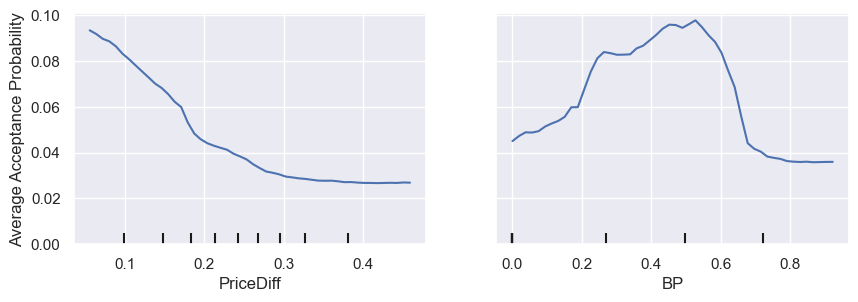

In [15]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['PriceDiff', 'PVnew'],
    # categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    n_cols = 2,  # This arranges the subplots in two columns
)

# xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
# disp.figure_.axes[1].set_xticklabels(xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['PriceDiff', 'BP']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(disp.axes_.ravel(), x_labels):
    ax.set_xlabel(label)

disp.axes_[0,0].set_ylabel('Average Acceptance Probability')
disp.axes_[0,0].set_ylim(bottom=0)
disp.axes_[0,1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

disp.figure_.set_size_inches(10,3)
disp.figure_.subplots_adjust(hspace=0.1)
plt.savefig(f'../plots/{scope}/explainer/pdp_price_pv_{scope}_test.png')

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_11159/4114077146.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(tech_xtick_names)
/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_11159/4114077146.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(prov_xtick_names)


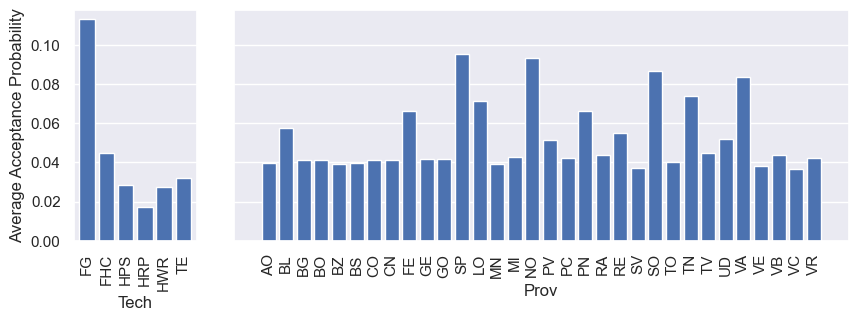

In [16]:
fig, axs = plt.subplots(1, 2, width_ratios=[1, 5], figsize=(10, 3), sharey=True)

disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'Prov'],
    categorical_features = ['Tech', 'Prov'],
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    # n_cols = 2,  # This arranges the subplots in two columns
    ax = axs
)

tech_xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
prov_xtick_names = [province_codes[prov] for prov in sorted(province_codes.keys())]
axs[0].set_xticklabels(tech_xtick_names)
axs[1].set_xticklabels(prov_xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['Tech', 'Prov']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(axs, x_labels):
    ax.set_xlabel(label)
    ax.grid(False, axis='x')

axs[0].set_ylabel('Average Acceptance Probability')
axs[1].set_ylabel(None)
axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

plt.subplots_adjust(wspace=0.1, hspace=0)  # Adjust space between the plots
plt.savefig(f'../plots/{scope}/explainer/pdp_cat_{scope}_test.png', bbox_inches='tight')

## SHAP

In [139]:
# Get the encoded dataframe passed as input to the model
X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_transformer.get_feature_names_out(), index=test_df.index)
X_test_df

,MargTech_Ccgt,MargTech_Altro,MargTech_Fer,MargTech_Carbone,MargTech_MC,MargTech_I.Fluente,MargTech_Estero,MargTech_I.Pompaggio,MargTech_I.Modulazione,MargTech_Oliocarbone,...,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,SolarAngle,DeclAngle,PVnew,PriceDiff
202201019UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.355640,0.400913,-1.419636,2.134212,11821.441,7560.569,-58.226106,-23.011637,0.009,-1.000
2022010110UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.764699,0.725429,-1.335997,2.190624,12571.768,7994.499,-43.226106,-23.011637,0.009,-1.000
2022010118UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.865003,-0.046641,-1.448027,2.029188,14194.819,10621.441,76.773894,-23.011637,0.113,-0.410
2022010119UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.547889,-0.089815,-1.441812,2.029095,14764.205,11054.919,91.773894,-23.011637,0.121,-0.415
2022010120UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.434714,-0.145514,-1.422603,1.976084,14932.035,11242.601,106.773894,-23.011637,0.121,-0.433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.806319,0.875068,-2.527147,1.535322,13549.450,11939.811,61.887169,-23.085911,0.540,-0.350
2022123118UP_VOGHERA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.329127,0.607693,-2.561474,1.487904,14776.994,14144.749,76.887169,-23.085911,1.000,-0.420
2022123119UP_VOGHERA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.293692,0.548271,-2.484197,1.335766,15015.332,14713.353,91.887169,-23.085911,1.000,-0.414
2022123120UP_VOGHERA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.385200,0.630366,-2.484197,1.335766,14903.585,14500.485,106.887169,-23.085911,1.000,-0.405


In [140]:
# Take a sample to explain
n_samples = 10000
X_test_sample_df = X_test_df.sample(n_samples, random_state=42)

In [141]:
explainer = shap.TreeExplainer(clf, feature_perturbation='tree_path_dependent', model_output='raw')
shap_values = explainer(X_test_sample_df, approximate=True)

NameError: name 'clf' is not defined

### SHAP feature importance

Group shap values for categorical variables

In [187]:
def group_categorical_shap(shap_values, feature_names, df_to_explain):
    n_expl = shap_values.shape[0]
    p_encoded = shap_values.shape[1]
    p = len(feature_names)

    group_map = np.zeros(p_encoded)
    for i, feature in enumerate(feature_names):
        for j, encoded_feature in enumerate(shap_values.feature_names):
            if encoded_feature.startswith(feature):
                group_map[j] = i

    group_shap_values = np.zeros((n_expl, p, 2))
    
    for group_id in range(p):
        features_to_group = np.where(group_map == group_id)[0]
        group_shap_values[:, group_id, :] = shap_values.values[:, features_to_group, :].sum(axis=1)

    group_shap_values = shap.Explanation(
        values=group_shap_values,
        base_values=shap_values.base_values,
        data=df_to_explain.loc[:, feature_names],
        feature_names=feature_names
    )
    return group_shap_values

In [185]:
group_shap_values = group_categorical_shap(shap_values, features, test_df.loc[X_test_sample_df.index, features])

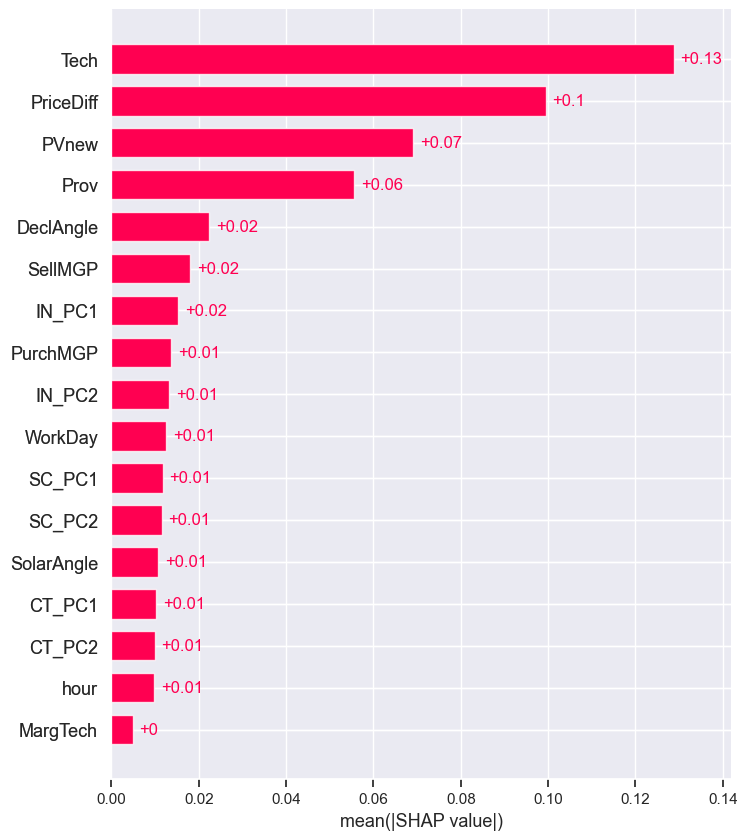

In [186]:
shap.plots.bar(group_shap_values[:, :, 1], max_display=17)

### SHAP dependence plot with numerical variables

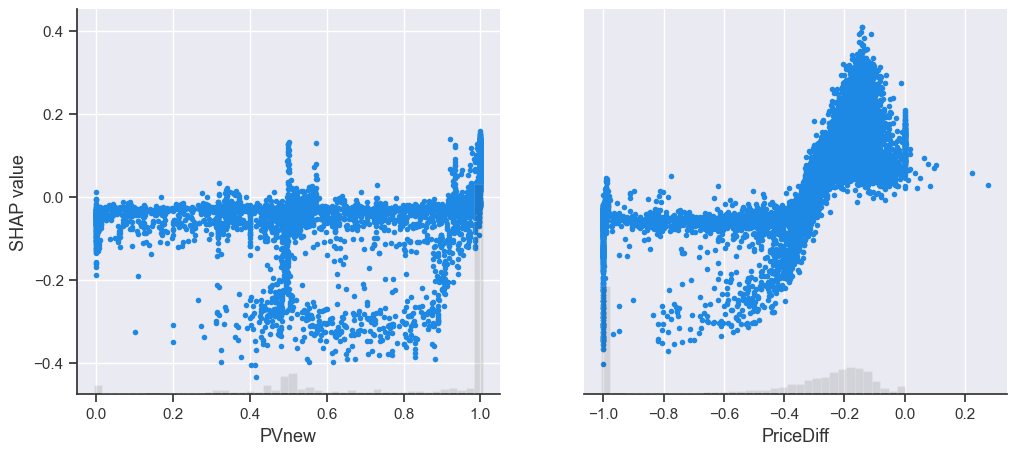

In [165]:
shap.plots.scatter(shap_values[:, ['PVnew', 'PriceDiff'], 1], show=True)

In [113]:
test_df.columns

Index(['hour', 'date', 'year', 'unit', 'scope', 'SC_PC1', 'SC_PC2', 'IN_PC1',
       'IN_PC2', 'CT_PC1', 'CT_PC2', 'PurchMGP', 'SellMGP', 'MargTech',
       'MGPprice', 'GNprice', 'SolarAngle', 'DeclAngle', 'WorkDay', 'Prov',
       'Tech', 'PVold', 'PVnew', 'Price', 'PriceDiff', 'Result', 'RatioAcc',
       'Qty'],
      dtype='object')

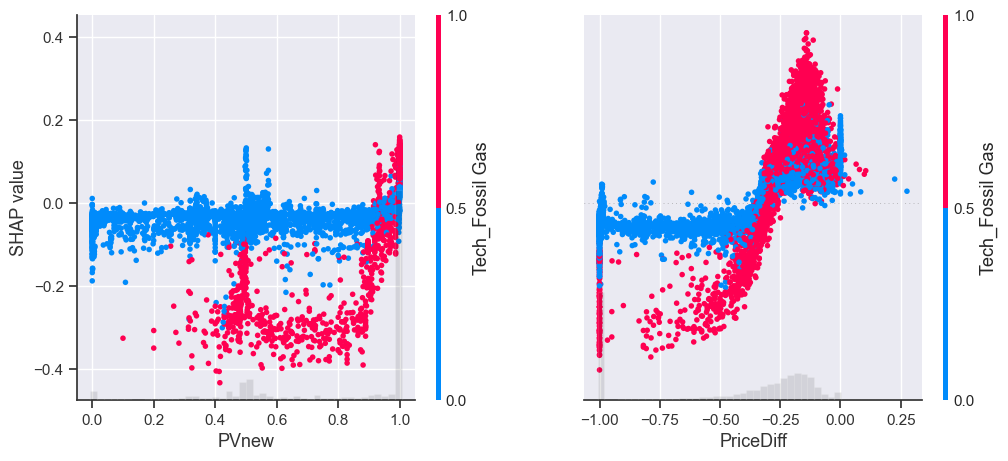

In [166]:
shap.plots.scatter(shap_values[:, ['PVnew', 'PriceDiff'], 1], color=shap_values[:, :, 1], show=True)

In [167]:
tech_shap_df = pd.DataFrame(index=X_test_sample_df.index)
tech_shap_df['Tech'] = test_df.loc[X_test_sample_df.index, "Tech"]
tech_shap_df['Shapley Value'] = agg_shap_values[:, "Tech", 1].values
tech_shap_df

,Tech,Shapley Value
2022021619UP_EDOLO_1_BID,Hydro Pumped Storage,-0.067556
2022061910UP_TAVAZZANO_5_BID,Fossil Gas,0.201397
2022040119UP_PIACENZA_4_BID,Fossil Gas,0.175811
202207033UP_PRACOMUNE_1_BID,Hydro Pumped Storage,-0.159895
202209308UP_LIRO_1_BID,Hydro Water Reservoir,-0.081985
...,...,...
202206201UP_RONCOVALG_1_BID,Hydro Pumped Storage,-0.065624
2022050617UP_BRUNICO_M_1_BID,Hydro Water Reservoir,-0.120268
202212103UP_LEVANTE_3_BID,Fossil Gas,0.223644
202209216UP_MONFALCO_1_BID,Fossil Hard coal,-0.139142


### SHAP dependence plot with categorical variables

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_5995/840218925.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


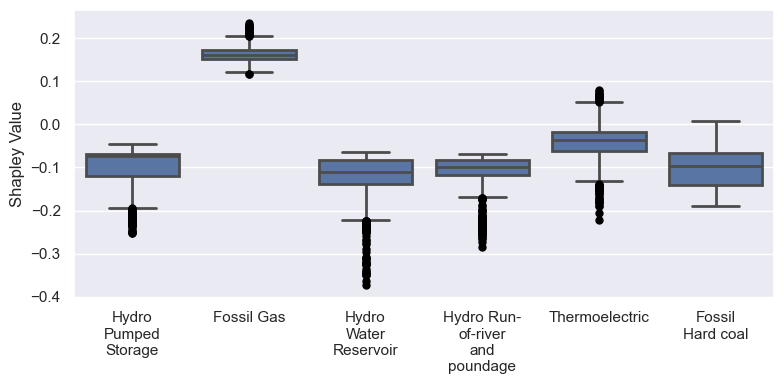

In [172]:
# Define custom properties for fliers
flierprops = {
    'marker': 'o',         # Circle marker
    'markerfacecolor': 'black',  # Red fill
    'markeredgecolor': 'black', # Black edge
    'markersize': 5,       # Adjust size
    'linestyle': 'none'    # No line connecting to fliers
}

plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=tech_shap_df,
    x='Tech',
    y='Shapley Value',
    # hue='daytype',
    # hue_order=daytype_order,
    # palette='inferno',
    linewidth=2,  # Set the thickness of the box frames
    flierprops=flierprops
)

ax.set_xlabel(None)
# ax.set_ylabel('Sha', fontsize=fontsize)
# ax.tick_params(axis='both', which='major')
# ax.legend(title=None, loc='upper center', ncols=4)

wrap_labels(ax, 10)
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_test_tech.png')

In [169]:
prov_shap_df = pd.DataFrame(index=X_test_sample_df.index)
prov_shap_df['Prov'] = test_df.loc[X_test_sample_df.index, "Prov"]
prov_shap_df['Shapley Value'] = agg_shap_values[:, "Prov", 1].values
prov_shap_df

,Prov,Shapley Value
2022021619UP_EDOLO_1_BID,Brescia,-0.026014
2022061910UP_TAVAZZANO_5_BID,Lodi,0.015196
2022040119UP_PIACENZA_4_BID,Piacenza,-0.027601
202207033UP_PRACOMUNE_1_BID,Bolzano,-0.022321
202209308UP_LIRO_1_BID,Sondrio,-0.040138
...,...,...
202206201UP_RONCOVALG_1_BID,Varese,0.024038
2022050617UP_BRUNICO_M_1_BID,Bolzano,-0.023629
202212103UP_LEVANTE_3_BID,Venezia,0.023185
202209216UP_MONFALCO_1_BID,Gorizia,-0.068898


/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_5995/508393418.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prov_xtick_names)


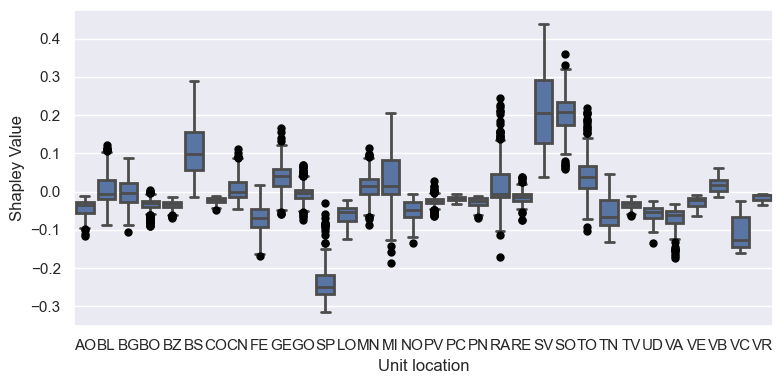

In [170]:
# Define custom properties for fliers
flierprops = {
    'marker': 'o',         # Circle marker
    'markerfacecolor': 'black',  # Red fill
    'markeredgecolor': 'black', # Black edge
    'markersize': 5,       # Adjust size
    'linestyle': 'none'    # No line connecting to fliers
}

plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=prov_shap_df,
    x='Prov',
    y='Shapley Value',
    # hue='daytype',
    # hue_order=daytype_order,
    # palette='inferno',
    linewidth=2,  # Set the thickness of the box frames
    flierprops=flierprops
)

ax.set_xlabel('Unit location')
prov_xtick_names = [province_codes[prov] for prov in sorted(province_codes.keys())]
ax.set_xticklabels(prov_xtick_names)
# ax.set_ylabel('Sha', fontsize=fontsize)
# ax.tick_params(axis='both', which='major')
# ax.legend(title=None, loc='upper center', ncols=4)

plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_test_prov.png')

## Compute SHAP values for all observations

In [149]:
years = [2019, 2020, 2021, 2022]
subsample = None
random_state = 42

df = input_df[input_df.year.isin(years)]
df['timestamp'] = pd.to_datetime(df['date'].astype(str) + df['hour'].apply(lambda x: "{:02d}".format(x-1)), format='%Y%m%d%H')
df['month'] = df['timestamp'].dt.to_period('M')

In [102]:
months = df.month.unique()
shap_df_list = []

for month in tqdm(months):
    df_to_explain = df[df.month == month]
    X_to_explain = pd.DataFrame(feature_transformer.transform(df_to_explain.loc[:, features]).toarray(), columns=feature_transformer.get_feature_names_out(), index=df_to_explain.index)
    if subsample:
        X_to_explain = X_to_explain.sample(subsample, random_state=random_state)

    model = joblib.load(join(model_folder, '{}.joblib'.format(month.strftime('%Y%m'))))
    
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation='tree_path_dependent',
        model_output='raw'
    )

    shap_values = explainer(X_to_explain, approximate=True)
    group_shap_values = group_categorical_shap(shap_values, features, df.loc[X_to_explain.index, features])

    shap_df = pd.DataFrame(group_shap_values.values[..., 1], columns=features, index=X_to_explain.index)

    shap_df_list.append(shap_df)

shap_df = pd.concat(shap_df_list)
shap_df

  0%|          | 0/48 [00:00<?, ?it/s]

NameError: name 'group_categorical_shap' is not defined

In [104]:
shap_df.to_pickle(join(scope, 'shap_values', f'shap_values_{scope}.pkl' ))

In [150]:
shap_df = pd.read_pickle(join(scope, 'shap_values', f'shap_values_{scope}.pkl' ))

In [151]:
shap_df.rename({'PVnew': 'BP'}, axis=1, inplace=True)

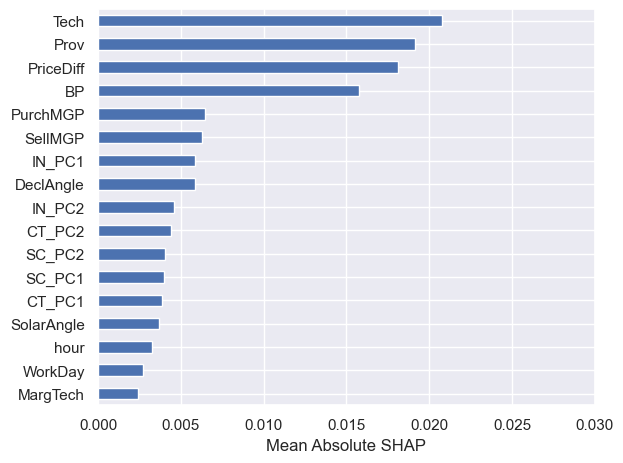

In [129]:
year = ''

if year:
    shap_df[df.year == year].abs().mean().sort_values(ascending=True).plot(kind='barh')
else:
    shap_df.abs().mean().sort_values(ascending=True).plot(kind='barh')

plt.xlabel('Mean Absolute SHAP')
if scope == 'BID':
    plt.xlim((0, 0.15))
else:
    plt.xlim((0, 0.030))
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_feature_imp_static{year}.png', dpi=300)

In [152]:
features = [feature if feature != 'PVnew' else 'BP' for feature in features]

In [153]:
features_ordering = shap_df.abs().mean().sort_values(ascending=False).index
monthly_fi = shap_df.abs().groupby(df.month).mean()
features_to_plot = ['Tech', 'BP', 'PriceDiff', 'Prov']
monthly_fi_plot = monthly_fi[features_to_plot]
monthly_fi_plot['Other features'] = monthly_fi[[feature for feature in features if feature not in features_to_plot]].sum(axis=1)
monthly_fi_plot

,Tech,BP,PriceDiff,Prov,Other features
month,,,,,
2019-01,0.086612,0.077343,0.045818,0.049099,0.100835
2019-02,0.080722,0.073407,0.047198,0.050941,0.100435
2019-03,0.089734,0.083842,0.043332,0.052101,0.117286
2019-04,0.087440,0.074468,0.040887,0.046287,0.109946
2019-05,0.083172,0.067599,0.044564,0.043033,0.104421
2019-06,0.080184,0.056088,0.051541,0.044857,0.103846
2019-07,0.083184,0.061663,0.043752,0.050513,0.092858
2019-08,0.093202,0.072714,0.051740,0.046854,0.118220
2019-09,0.100907,0.073723,0.054206,0.053256,0.110995


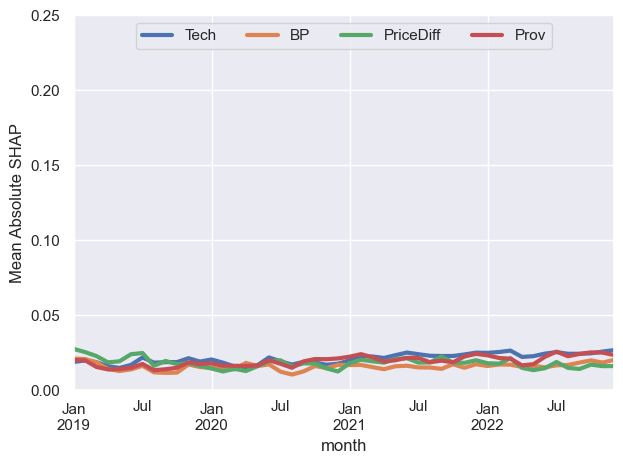

In [132]:
# Your plot
ax = monthly_fi[features_to_plot].plot(ylim=(0, 0.25), linewidth=3)

# Customize the legend
# Move legend to the right
ax.legend(loc='upper center',
        #   bbox_to_anchor=(1.05, 0.5),
        ncol=4,
        # frameon=False
        )

plt.ylabel("Mean Absolute SHAP")
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_feature_imp.png', dpi=300)

In [154]:
shap_with_data = pd.concat([shap_df.add_prefix('shap_'), df.rename({'PVnew': 'BP'}, axis=1)], axis=1)

In [155]:
shap_with_data['Tech_Gas'] = shap_with_data.Tech.apply(lambda s: 'Fossil Gas' if s == 'Fossil Gas' else 'Other')

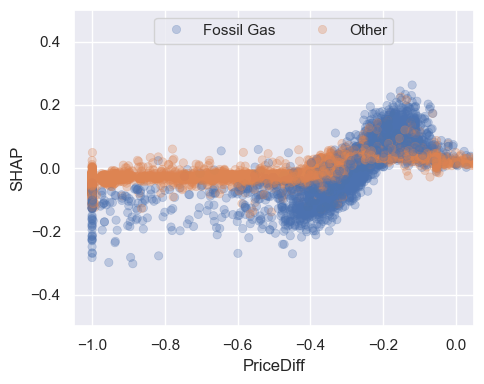

In [156]:
year = 2019

fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(
        data=shap_with_data[shap_with_data.year == year].sample(10000, random_state=42),
        # data=shap_with_data.sample(10000, random_state=42),
        x='PriceDiff', y='shap_PriceDiff', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
)
if scope == 'BID':
        plt.xlim((-1.05, 0.05))
        plt.ylim((-0.5, 0.5))
else:
        plt.xlim((-0.25, 1.05))
#         plt.ylim((-0.5, 0.5))

plt.legend(
        loc='upper center',
        ncol=2,
        # frameon=False
)
plt.ylabel('SHAP')
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_dependence_PriceDiff{year}.png', dpi=300)

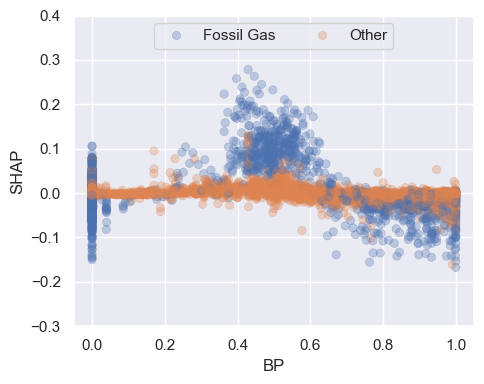

In [136]:
year = ''

fig, ax = plt.subplots(figsize=(5, 4))
if year:
        sns.scatterplot(
                data=shap_with_data[shap_with_data.year == year].sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='BP', y='shap_BP', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
else:
        sns.scatterplot(
                data=shap_with_data.sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='BP', y='shap_BP', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
if scope == 'BID':
        # plt.xlim((0.8, 1))
        plt.ylim((-0.5, 0.5))
else:
        # plt.xlim((-1.05, 0.05))
        plt.ylim((-0.3, 0.4))

plt.legend(
        loc='upper center',
        ncol=2,
        # frameon=False
)
plt.ylabel('SHAP')
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_dependence_BP{year}.png', dpi=300)

In [137]:
tech_order = ['Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Hydro Pumped Storage', 'Fossil Gas', 'Thermoelectric', 'Fossil Hard coal']

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_6276/840218925.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


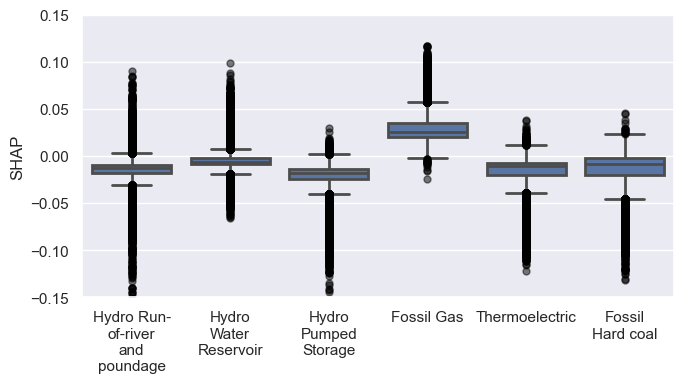

In [138]:
year = 2019

# Define custom properties for fliers
flierprops = {
    'marker': 'o',         # Circle marker
    'markerfacecolor': 'black',  # Red fill
    'markeredgecolor': 'black', # Black edge
    'markersize': 5,       # Adjust size
    'linestyle': 'none',    # No line connecting to fliers
    'alpha': 0.5
}

plt.figure(figsize=(7, 4))
ax = sns.boxplot(
    data=shap_with_data[shap_with_data.year == year],
    x='Tech',
    y='shap_Tech',
    order=tech_order,
    # hue='daytype',
    # hue_order=tech_order,
    # palette='inferno',
    linewidth=2,  # Set the thickness of the box frames
    flierprops=flierprops
)

ax.set_xlabel(None)
# ax.set_ylabel('Sha', fontsize=fontsize)
# ax.tick_params(axis='both', which='major')
# ax.legend(title=None, loc='upper center', ncols=4)

wrap_labels(ax, 10)
plt.ylabel('SHAP')
if scope == 'BID':
    plt.ylim((-0.5, 0.5))
else:
    plt.ylim((-0.15, 0.15))
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_tech{year}.png', dpi=300)

In [158]:
shap_prov = shap_with_data.groupby('Prov')['shap_Prov'].mean().rename(province_codes)
gdf = gpd.read_file('../data/georef-italy-provincia')
gdf = gdf.merge(shap_prov, left_on='prov_sigla', right_index=True, how='left')
gdf['shap_Prov'] = gdf['shap_Prov'].fillna(0)
gdf = gdf[gdf.rip_name.isin(['Nord-Ovest', 'Nord-Est'])]
gdf.head()

,year,rip_code,rip_name,reg_code,reg_name,prov_code,prov_name,prov_name_u,prov_name_l,prov_area_c,prov_type,prov_sigla,geometry,shap_Prov
1,2022,1,Nord-Ovest,3,Lombardia,18,Pavia,PAVIA,pavia,ITA,Provincia,PV,"MULTIPOLYGON (((8.81427 45.01739, 8.81295 45.0...",0.102544
3,2022,2,Nord-Est,4,Trentino-Alto Adige,21,Bolzano,BOLZANO,bolzano,ITA,Provincia autonoma,BZ,"POLYGON ((12.47759 46.67982, 12.47518 46.67888...",-0.039568
4,2022,2,Nord-Est,5,Veneto,227,Venezia,VENEZIA,venezia,ITA,Citta metropolitana,VE,"POLYGON ((12.66165 45.79243, 12.6632 45.79217,...",-0.005846
5,2022,1,Nord-Ovest,7,Liguria,11,La Spezia,LA SPEZIA,la spezia,ITA,Provincia,SP,"MULTIPOLYGON (((9.85137 44.02382, 9.85122 44.0...",0.032245
8,2022,1,Nord-Ovest,3,Lombardia,14,Sondrio,SONDRIO,sondrio,ITA,Provincia,SO,"POLYGON ((9.5269 46.01151, 9.52734 46.0126, 9....",-0.023402


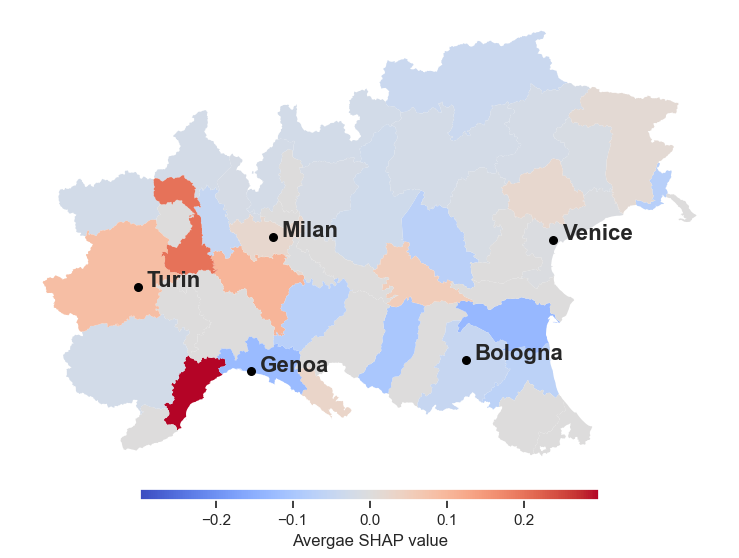

In [159]:
# Example: city coordinates (latitude, longitude)
cities = {
    "Milan": (45.4642, 9.1900),
    # "Rome": (41.9028, 12.4964),
    # "Naples": (40.8518, 14.2681),
    "Turin": (45.0703, 7.6869),
    "Venice": (45.4408, 12.3155),
    # "Florence": (43.7696, 11.2558),
    "Genoa": (44.4056, 8.9463),
    "Bologna": (44.4949, 11.3426)
}

# Create a DataFrame
city_df = pd.DataFrame({
    "city": list(cities.keys()),
    "lat": [coord[0] for coord in cities.values()],
    "lon": [coord[1] for coord in cities.values()]
})

# Convert to GeoDataFrame
city_gdf = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.lon, city_df.lat), crs="EPSG:4326")

# Assuming `merged` is your choropleth-ready GeoDataFrame
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(column='shap_Prov', cmap='coolwarm', legend=True, ax=ax, vmin=-max(abs(gdf["shap_Prov"])), vmax=max(abs(gdf["shap_Prov"])),
         edgecolor='none',
    legend_kwds={
        'orientation': 'horizontal',
        'shrink': 0.6,         # Shrinks the height of the color bar
        'aspect': 40,          # Makes it narrower
        'pad': 0.02,           # Space between map and color bar
        'label': "Avergae SHAP value"  # Optional label
    })


# # Add province codes
# for idx, row in gdf.iterrows():
#     ax.annotate(text=row.prov_sigla, xy=(row.geometry.centroid.x, row.geometry.centroid.y),
#                 xytext=(0, 0), textcoords="offset points", fontsize=12, color='white',
#                 ha='center', va='center', zorder=6, fontweight='normal')
    
# Plot cities
city_gdf.plot(ax=ax, color='black', markersize=30)
for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf["city"]):
    ax.text(x + 0.1, y, label, fontsize=16, fontdict={'weight':'bold'}, zorder=10)

# plt.title("Average SHAP value per Province")
plt.axis('off')
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_Prov.png', dpi=300, bbox_inches='tight')

## Accumulated Local Effects (ALE)

In [17]:
if run_ALE:
    predictor = clf.predict_proba

    # Features to explain should be numerical or ordinal
    encoded_feature_names = list(feature_transformer.get_feature_names_out())
    features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVnew', 'PriceDiff', 'IN_PC1']]

    ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
    ale = ale.explain(X_test.toarray(), features=features_to_explain)

    plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
    plt.tight_layout()

<HR>

# TESTS